<a href="https://colab.research.google.com/github/aldnoahh/plant-disease-recognition/blob/master/PDR_VGG19_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant Disease Recognition using VGG19 on modified version of PlantVillage Dataset.

Importing necessary libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg19 import VGG19 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

Downloading and unzipping the modified dataset available on Gdrive. If you don`t have gdown module, install it using pip.

In [ ]:
!gdown --id 1Mj6wsKBZN2ycAyyIMs2lI361deuCJqBI --output pv0.zip
!unzip pv0.zip

Check if the folder has been unzipped.

In [4]:
!ls

pv0  pv0.zip  sample_data


Setting up path for datagenerators from keras

In [5]:
train_path = '/content/pv0/train'
valid_path = '/content/pv0/test'
# useful for getting number of files
image_files = glob(train_path + '/*/*.JPG')
valid_image_files = glob(valid_path + '/*/*.JPG')
# useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)

38

Specify input image size.

In [6]:
IMAGE_SIZE = [256, 256]

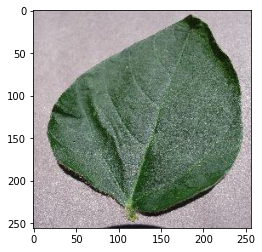

In [7]:
#sneek peek at a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Configuring the pretrainned model as per our needs.

In [8]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)
# freeze pretrained model weights
ptm.trainable = False

80142336/80134624 [==============================] - 0s 0us/step


In [9]:
K = len(folders) # number of classes

#model definition
x = Flatten()(ptm.output)
x= BatchNormalization()(x)
x= Dense(512,activation='relu')(x)
x = Dense(K, activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [11]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [12]:
#view the number of layers in the model
len(model.layers)

26

In [13]:
# create an instance of ImageDataGenerator
#Keras generators returns one-hot encoded labels and provides data augmentation.
gen_train = ImageDataGenerator(
  rotation_range=90,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [14]:
#batch size is the number of examples that are run through the model at once.
batch_size = 300

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 46141 images belonging to 38 classes.
Found 8162 images belonging to 38 classes.


Since Keras no longer provides some metrics within itself, so we define those metrics ourselves. Here, we are defining F1_score, Precision and Recall.

In [15]:
from keras import backend as Ke

def recall_m(y_true, y_pred):
    true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
    possible_positives = Ke.sum(Ke.round(Ke.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + Ke.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
    predicted_positives = Ke.sum(Ke.round(Ke.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Ke.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+Ke.epsilon()))

This block is for creating a lr scheduler, since the lr scheduler was not as effective as using adam directly, it is left for experimentation.

In [16]:
# from keras.optimizers import SGD
# import math
# def step_decay(epoch):
# 	initial_lrate = 1e-4
# 	drop = 0.5
# 	epochs_drop = 10.0
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	return lrate
# sgd = SGD(lr=0.0, momentum=0.9)
# # learning schedule callback
# from keras.callbacks import LearningRateScheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate]

Compiling our model with loss, optimizer and metrics (including our custom defined ones).

In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m]
)

The fit function is called for starting our training. 


In [18]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/5
150/150 [==============================] - 795s 5s/step - loss: 0.7822 - accuracy: 0.8552 - f1_m: 0.8575 - precision_m: 0.8668 - recall_m: 0.8489 - val_loss: 0.6398 - val_accuracy: 0.9083 - val_f1_m: 0.9091 - val_precision_m: 0.9116 - val_recall_m: 0.9065
Epoch 2/5
150/150 [==============================] - 768s 5s/step - loss: 0.3244 - accuracy: 0.9265 - f1_m: 0.9274 - precision_m: 0.9322 - recall_m: 0.9227 - val_loss: 0.2975 - val_accuracy: 0.9395 - val_f1_m: 0.9406 - val_precision_m: 0.9434 - val_recall_m: 0.9379
Epoch 3/5
150/150 [==============================] - 758s 5s/step - loss: 0.2359 - accuracy: 0.9396 - f1_m: 0.9411 - precision_m: 0.9459 - recall_m: 0.9364 - val_loss: 0.2293 - val_accuracy: 0.9496 - val_f1_m: 0.9502 - val_precision_m: 0.9531 - val_recall_m: 0.9474
Epoch 4/5
150/150 [==============================] - 755s 5s/step - loss: 0.1881 - accuracy: 0.9482 - f1_m: 0.9491 - precision_m: 0.9533 - recall_m: 0.9449 - val_loss: 0.1689 - val_accuracy: 0.9570 - va

Saving our Model in HD5 format.

In [19]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


Graphs for our metrics

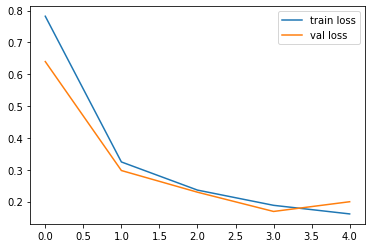

In [20]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

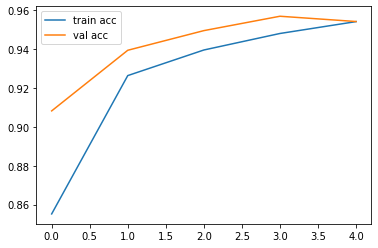

In [21]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

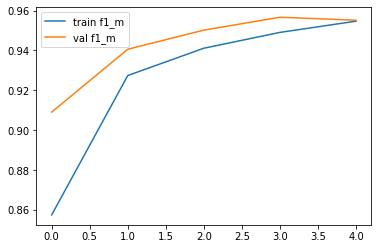

In [22]:
# f1_score
plt.plot(r.history['f1_m'], label='train f1_m')
plt.plot(r.history['val_f1_m'], label='val f1_m')
plt.legend()
plt.show()

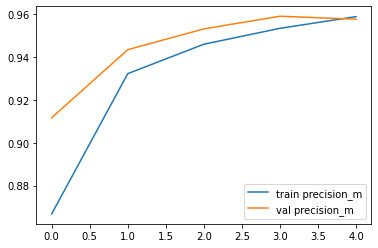

In [23]:
# precision
plt.plot(r.history['precision_m'], label='train precision_m')
plt.plot(r.history['val_precision_m'], label='val precision_m')
plt.legend()
plt.show()

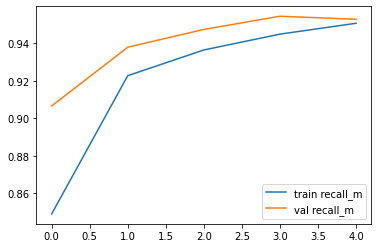

In [24]:
# recall
plt.plot(r.history['recall_m'], label='train recall_m')
plt.plot(r.history['val_recall_m'], label='val recall_m')
plt.legend()
plt.show()

Next we evaluate the model on our test set again.

In [25]:
# evaluate the model
valid_generator = gen_test.flow_from_directory(valid_path,target_size=IMAGE_SIZE,batch_size=batch_size,)
loss, accuracy, f1_score, precision, recall = model.evaluate(valid_generator, steps=int(np.ceil(len(valid_image_files)/ batch_size)))

Found 8162 images belonging to 38 classes.
27/27 [==============================] - 57s 2s/step - loss: 0.1991 - accuracy: 0.9547 - f1_m: 0.9554 - precision_m: 0.9577 - recall_m: 0.9531


Printing our metrics

In [26]:
print('loss     : ',loss)
print('accuracy : ',accuracy)
print('f1_score :',f1_score)
print('precision:',precision)
print('recall   :',recall)

loss     :  0.19907443225383759
accuracy :  0.9546913504600525
f1_score : 0.9553820490837097
precision: 0.9576932191848755
recall   : 0.9530863761901855
